# **Imports Libraries**

---



In [181]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,SimpleRNN,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# **Import Dataset**

---



In [182]:
!gdown --id '1PqDvPJuYZBUCM7l0loB4xcnqfWw8LzCj'

Downloading...
From: https://drive.google.com/uc?id=1PqDvPJuYZBUCM7l0loB4xcnqfWw8LzCj
To: /content/Dataset_3.csv
100% 999k/999k [00:00<00:00, 64.8MB/s]


In [183]:
train=pd.read_csv("Dataset_3.csv", encoding = "ISO-8859-1")
train.head()

,tweets,sentiment
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [184]:
train["length"]=train["tweets"].apply(len)

In [185]:
train.head()

,tweets,sentiment,length
0,just had a real good moment. i missssssssss hi...,0,57
1,is reading manga http://plurk.com/p/mzp1e,0,42
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,84
3,@lapcat Need to send 'em to my accountant tomo...,0,135
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,45


In [186]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweets     10314 non-null  object
 1   sentiment  10314 non-null  int64 
 2   length     10314 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


In [187]:
train.isnull().sum()

tweets       0
sentiment    0
length       0
dtype: int64

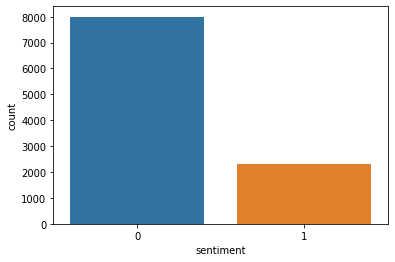

In [188]:
import seaborn as sns
sns.countplot(train["sentiment"])

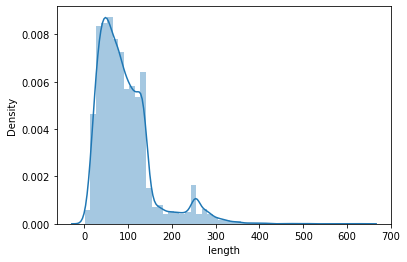

In [189]:
sns.distplot(train["length"])

# **Data Preprocessing**

---



In [190]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## **Number of stopwords in each tweet**

In [191]:
nltk.download('stopwords')
stop=stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [192]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [193]:
def stop_words(df):
    df['stopwords'] = df['tweets'].apply(lambda x: len([x for x in x.split() if x in stop]))
    print(df[['tweets','stopwords']].head())

In [194]:
stop_words(train)

                                              tweets  stopwords
0  just had a real good moment. i missssssssss hi...          6
1         is reading manga  http://plurk.com/p/mzp1e          1
2  @comeagainjen http://twitpic.com/2y2lx - http:...          0
3  @lapcat Need to send 'em to my accountant tomo...          7
4      ADD ME ON MYSPACE!!!  myspace.com/LookThunder          0


## **Web address, Twitter id Removal**

In [195]:
def www_id_digit_removal(df):  
    df['tweets'] = df['tweets'].apply(lambda x: " ".join(x for x in x.split() if (x[0] != '@') & ('http' not in x)& ('.com' not in x)))
    print(df['tweets'].head())

In [196]:
www_id_digit_removal(train)

0    just had a real good moment. i missssssssss hi...
1                                     is reading manga
2                                                    -
3    Need to send 'em to my accountant tomorrow. Od...
4                                 ADD ME ON MYSPACE!!!
Name: tweets, dtype: object


In [197]:
train.isnull().sum()

tweets       0
sentiment    0
length       0
stopwords    0
dtype: int64

## **Punctuation Marks Removal**

In [198]:
def punctuation_removal(df):
    df['tweets'] = df['tweets'].str.replace('[^\w\s]','')
    print(df['tweets'].head())

In [199]:
punctuation_removal(train)

0    just had a real good moment i missssssssss him...
1                                     is reading manga
2                                                     
3    Need to send em to my accountant tomorrow Oddl...
4                                    ADD ME ON MYSPACE
Name: tweets, dtype: object


## **Most Frequent Words Removal**

In [200]:
freq = pd.Series(' '.join(train['tweets']).split()).value_counts()[:10]
freq

to            3758
the           3448
a             2949
I             2839
and           2574
you           2143
depression    1807
of            1778
my            1705
is            1659
dtype: int64

In [201]:
freq = list(freq.index)
freq

['to', 'the', 'a', 'I', 'and', 'you', 'depression', 'of', 'my', 'is']

In [202]:
freq.remove('depression')
freq

['to', 'the', 'a', 'I', 'and', 'you', 'of', 'my', 'is']

In [203]:
#Removing the most frequent words from the dataset
def frequent_words_removal(df):  
    df['tweets'] = df['tweets'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    print(df['tweets'].head())

In [204]:
frequent_words_removal(train)

0    just had real good moment i missssssssss him s...
1                                        reading manga
2                                                     
3    Need send em accountant tomorrow Oddly wasnt e...
4                                    ADD ME ON MYSPACE
Name: tweets, dtype: object


In [205]:
train.isnull().sum()

tweets       0
sentiment    0
length       0
stopwords    0
dtype: int64

## **Rare Words Removal**

In [206]:
freq = pd.Series(' '.join(train['tweets']).split()).value_counts()[-10:]
freq

Keough         1
snakebite      1
phenomenal     1
Recovering     1
refreshment    1
Roman          1
deffo          1
waves          1
Iver           1
Aluminum       1
dtype: int64

In [207]:
freq = list(freq.index)
def rare_words_removal(df):
    df['tweets'] = df['tweets'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    print(df['tweets'].head())

In [208]:
rare_words_removal(train)

0    just had real good moment i missssssssss him s...
1                                        reading manga
2                                                     
3    Need send em accountant tomorrow Oddly wasnt e...
4                                    ADD ME ON MYSPACE
Name: tweets, dtype: object


In [209]:
train.isnull().sum()

tweets       0
sentiment    0
length       0
stopwords    0
dtype: int64

In [210]:
stop_words(train)

                                              tweets  stopwords
0  just had real good moment i missssssssss him s...          5
1                                      reading manga          0
2                                                             0
3  Need send em accountant tomorrow Oddly wasnt e...          1
4                                  ADD ME ON MYSPACE          0


## **Stemming and Removing Stopwords**

In [211]:
stemmer=PorterStemmer()

In [212]:
corpus=[]
for i in range(len(train)):
    #replacing everything other than alphabets with a space
    review=re.sub("[^a-zA-Z]"," ",str(train["tweets"][i]))
    #Lowering the tweets
    review=review.lower()
    #Converting in a list
    review=review.split()
    #Finding and removing stopwords
    review=[stemmer.stem(word) for word in review if not word in set(stopwords.words("english"))]
    #Joining after removal of stopwords
    review=" ".join(review)
    corpus.append(review)

In [213]:
corpus

['real good moment missssssssss much',
 'read manga',
 '',
 'need send em account tomorrow oddli wasnt even refer tax support evid though',
 'add myspac',
 'sleepi good time tonight though',
 'nbn someon alreadi said fiber home mean least regular',
 'c possibl today nice',
 'nite twittervil workout ciao',
 'night darlin sweet dream',
 'good morn everybodi',
 'final creat wordpress blog there alreadi blog seattl coffe commun',
 'kisha cnt get u til get frm u rememb ur top',
 'ye rememb band awesom pleas repli',
 'realli love reflect shadow',
 'ooo fantasi like fantasi novel check',
 'prob sell noth blog ill get listen band itun',
 'quotnokla connect peoplequot',
 'stay late start earli good thing like job',
 'read new job congratul that fantast',
 'havent abl sleep think ill watch ugli betti onlin',
 'woo thank ron steev follow yeow folowerssss haha ps wanna got ellen show',
 'yeah sure sister take extra gd care',
 'yay duck want anyth watch itd duck lol',
 'smaaack ass hahhahahaa make 

## **Creating TFIDF**

In [214]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv=TfidfVectorizer()
X=tfv.fit_transform(corpus).toarray()
y=train["sentiment"]

## **Splitting Dataset**

In [215]:
#taking dictionary size 5000
vocab_size = 5000

#one hot encoding
one_hot_dir = [one_hot(words,vocab_size) for words in corpus]

#length of all rows should be equal therefore applying padding
#this will adjust size by adding 0 at staring of the shorter rows
embedded_layer = pad_sequences(one_hot_dir,padding = 'pre')
embedded_layer

array([[   0,    0,    0, ..., 2806, 3322,  439],
       [   0,    0,    0, ...,    0,  552, 4106],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ..., 4198,  168, 1603],
       [   0,    0,    0, ..., 4198, 4714, 3803],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [216]:
X = np.array(embedded_layer)
y = np.array(y)

In [217]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [218]:
X_train.shape,y_train.shape

((8251, 50), (8251,))

In [219]:
X_test.shape,y_test.shape

((2063, 50), (2063,))

# **Model**

---

In [221]:
embed_vec_length = 32
model = Sequential()
model.add(Embedding(vocab_size,embed_vec_length,input_length = len(X_train[0])))
model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(128))
model.add(Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 32)            160000    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 50, 128)           20608     
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 213,633
Trainable params: 213,633
Non-trainable params: 0
_________________________________________________________________


In [222]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 10, batch_size = 256)

Epoch 1/10
33/33 [==============================] - 8s 175ms/step - loss: 0.4667 - accuracy: 0.7902 - val_loss: 0.3722 - val_accuracy: 0.8536
Epoch 2/10
33/33 [==============================] - 5s 164ms/step - loss: 0.1997 - accuracy: 0.9257 - val_loss: 0.1428 - val_accuracy: 0.9578
Epoch 3/10
33/33 [==============================] - 5s 163ms/step - loss: 0.0518 - accuracy: 0.9851 - val_loss: 0.0958 - val_accuracy: 0.9699
Epoch 4/10
33/33 [==============================] - 5s 163ms/step - loss: 0.0223 - accuracy: 0.9952 - val_loss: 0.0671 - val_accuracy: 0.9792
Epoch 5/10
33/33 [==============================] - 5s 164ms/step - loss: 0.0136 - accuracy: 0.9976 - val_loss: 0.0768 - val_accuracy: 0.9772
Epoch 6/10
33/33 [==============================] - 5s 164ms/step - loss: 0.0099 - accuracy: 0.9981 - val_loss: 0.0680 - val_accuracy: 0.9816
Epoch 7/10
33/33 [==============================] - 5s 163ms/step - loss: 0.0071 - accuracy: 0.9988 - val_loss: 0.0805 - val_accuracy: 0.9782
Epoch 

In [223]:
model.save('/content/')

INFO:tensorflow:Assets written to: /content/assets


In [224]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

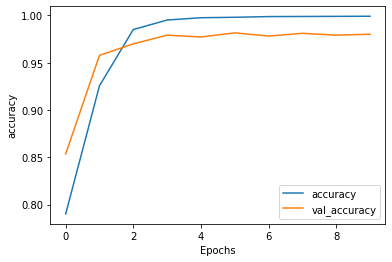

In [225]:
plot_graphs(history, "accuracy")

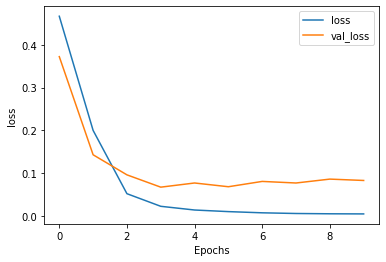

In [226]:
plot_graphs(history, "loss")

In [227]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [228]:
len(y_pred)

2063

In [229]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[1563,   10],
       [  31,  459]])

In [242]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [243]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test,y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test,y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,y_pred)
print('F1 score: %f' % f1)

# confusion matrix
matrix = confusion_matrix(y_test,y_pred)
print(matrix)

Accuracy: 0.980126
Precision: 0.978678
Recall: 0.936735
F1 score: 0.957247
[[1563   10]
 [  31  459]]


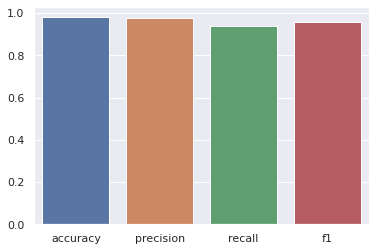

In [269]:
import seaborn as sns
sns.set()
scores = ['accuracy','precision','recall','f1']
values = [accuracy,precision,recall,f1]
sns.barplot(x=scores,y=values)

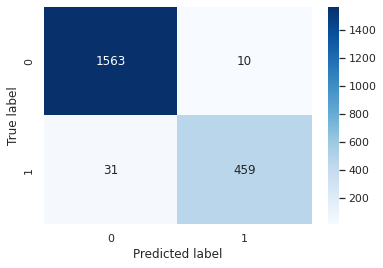

In [262]:
sns.heatmap(matrix, annot=True, fmt="d", cmap ="Blues") # font size
plt.xlabel("Predicted label") 
plt.ylabel("True label") 
plt.show()

# **Prediction**

---



In [232]:
import tensorflow as tf
def predict_sentiment(text):
  review=re.sub("[^a-zA-Z]"," ",str(text))
  #Lowering the tweets
  review=review.lower()
  #Converting in a list
  review=review.split()
  #Finding and removing stopwords
  review=[stemmer.stem(word) for word in review if not word in set(stopwords.words("english"))]
  #Joining after removal of stopwords
  review=" ".join(review)
  # print("here===",review)
  one_hot_dir = [one_hot(words,vocab_size) for words in [review]]

  #length of all rows should be equal therefore applying padding
  #this will adjust size by adding 0 at staring of the shorter rows
  embedded_layer = pad_sequences(one_hot_dir,padding = 'pre')
  
  embedded_layer = np.array(embedded_layer)
  output = model(embedded_layer)
  prediction = output.numpy()
  prediction = prediction[0][0]
  # print(prediction)
  
  if prediction < 0.5:
    print(f'{prediction:0.3}: Positive sentiment')
    return 1
  else:
    print(f'{prediction:0.3}: Negative sentiment')
    return 0

In [233]:
test_review_neg = "My mom died last week. I don't have any relatives. I'm alone and it is so hard. Today is the first day without anxiety and depression. I wanna live, I will not give up, I will fight like my mother did."
predict_sentiment(test_review_neg)

1.0: Negative sentiment


0

In [234]:
test_review_neg = "hopes the sun will stay now - fleamarket tomorrow, get out the change  http://plurk.com/p/vh81e"
predict_sentiment(test_review_neg)

6.81e-05: Positive sentiment


1

In [235]:
test_review_neg = "so excited 2day, looking 4ward 2 my long weekend "
predict_sentiment(test_review_neg)

0.000864: Positive sentiment


1